In [1]:
from saxs_data_processing import io, manipulate, target_comparison, subtract, sasview_fitting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# saxs_data_processing example usage

This notebook walks through some examples of how this library can be used to automate small-angle x-ray scattering data analysis. It covers loading data, performing background subtraction, fitting parametric models, and evaluating samples with distance metrics. It uses example data from an autonomous optimization campaign for silica nanoparticle diameter optimization. Functions make a few assumptions about how your data is structured and collected:
- Samples are identified with a UUID4 unique ID. This ID is generated at sample composition generation, and use to track sample information throughout the synthesis, characterization, and data processing steps.
- Samples are measured using the same detector configuration. Generally we are using the xenocs esaxs (extremely small angle x-ray scattering) detector configuration in this project.
- Samples are synthesized in batches, and data is organized in directories by batch.

## 1. Load example data 

Everything in this module starts from reduced, 1-dimensional 3-column data (with q, I, and sig. columns). In particular, the data-loading utilities were developed for .dat files from a Xenocs Xeuss instrument and have not been tested with data from other sources. 

The `io.read_1D_data` function is the simplest option for loading single .dat files. It takes a filepath and returns a tuple containing a 3-column Pandas dataframe for data, and a dictionary with metadata. When taking SAXS measurements, we measure scattering for both our sample and a background containing everything but our sample (more on this in the subraction section). Let's load both for an example measurement:

In [2]:
example1_data, example1_metadata = io.read_1D_data('example_data/2024_10_07_RandomSamples/03327_G7-T2_3ae01d8c-6757-4aa4-8701-a4f231f6a81c_000.dat')
example1background_data, example1background_metadata = io.read_1D_data('example_data/2024_10_07_RandomSamples/03289_H6-T2_EtOH_background_1_000.dat')

In [3]:
example1_data

,q,I,sig
0,0.000076,8.867842e+06,2099.629348
1,0.000229,8.312661e+06,1437.436601
2,0.000382,6.961679e+06,831.966142
3,0.000535,5.396190e+06,732.474132
4,0.000688,4.047607e+06,536.146909
...,...,...,...
900,0.137607,0.000000e+00,0.236458
901,0.137760,0.000000e+00,0.206901
902,0.137913,0.000000e+00,0.236460
903,0.138066,0.000000e+00,0.551741


When working with saxs data, it is common to measure a batch of related samples in one sitting. In this case, we only need to measure one background and can use it to process multiple sample measurements. The `io.load_biocube_data_with_background` function helps manage data loading in this situtation. This function looks for sample data in the same directory as background files you tell it about. It requires several conditions to be true to be useful:
- Data was collected with the BioCube sample changer on a Xenocs instrument
- Sample data files are named with a UUID4 ID in their file name
- Sample data files are organized into the same directory as their associated background data file.
If all these assumptions are met, this can streamline your data loading.

First, define a list of background .dat files for your measurements:

In [4]:
background_fps = ['example_data/2024_12_10_OptimizationExample/03734_D5-T2_Ethanol_background_1_000.dat',
                  'example_data/2024_10_07_RandomSamples/03289_H6-T2_EtOH_background_1_000.dat']

We also need to know the 'biocube config' number of the detector configuration the data was measured at. This is a xenocs-specific number that corresponds to detector distances like 'esaxs', 'saxs', 'maxs', and 'waxs'. In our case, our data was collected in the 'esaxs' configuration, which has a biocube config of '24'. The `io.load_biocube_data_with_background` function takes our list of background filepaths and our biocube config as inputs, and returns 3 objects: a dictionary mapping {uuid:(sample_data, sample_metadata)}, a dictionary mapping {uuid:(background_data, background_metadata)}, and a dictionary mapping {uuid:associated filepath}.

In [5]:
sample_data, uuid2bkg, data_fps = io.load_biocube_data_with_background(background_fps, 24)

In [6]:
data_fps

{'547378d7-9885-4f7b-bb76-1cad9fe9ecbe': 'example_data/2024_12_10_OptimizationExample/03737_A2-T2_547378d7-9885-4f7b-bb76-1cad9fe9ecbe_000.dat',
 'dd0c2d6b-3300-485f-a910-3edbad96b555': 'example_data/2024_12_10_OptimizationExample/03747_A12-T2_dd0c2d6b-3300-485f-a910-3edbad96b555_000.dat',
 '3ae01d8c-6757-4aa4-8701-a4f231f6a81c': 'example_data/2024_10_07_RandomSamples/03327_G7-T2_3ae01d8c-6757-4aa4-8701-a4f231f6a81c_000.dat'}

Let's take a look at the data we have loaded:

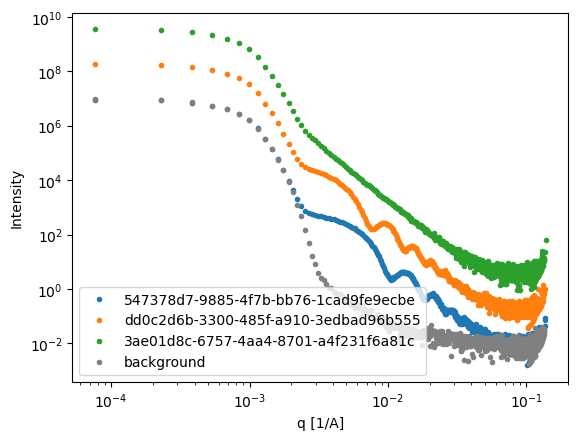

In [7]:
fig, ax = plt.subplots()

for i, (uuid_val, data_tuple) in enumerate(sample_data.items()):
    data = data_tuple[0]
    ax.loglog(data['q'], data['I']*20**i, label = uuid_val, ls = '', marker = '.')
    ax.set_xlabel('q [1/A]')
    ax.set_ylabel('Intensity')

bkg = uuid2bkg['547378d7-9885-4f7b-bb76-1cad9fe9ecbe'][0]
ax.loglog(bkg['q'], bkg['I'], label = 'background', ls = '', marker = '.', color = 'gray')

ax.legend(loc = 'lower left')

This is the 1-dimensional, reduced data from our measurement for our 3 samples. The y-axis (intensity) is arbitrary (we are not measuring absolute intensity) so we can shift the intensities to make for easier viewing.

## 2. Subract the background and select a valid data range

When we take a SAXS measurement, we are interested in measuring how our sample of interest interacts with X-rays. However, there are a lot of things that are not our sample that also interact with our X-rays, including our sample container and our solvent or dispersant. Fortunately, scattering is linearly additive, so we can simply subtract a measurement of everything except our sample to recover the scattering due to our sample. This is known as background subtraction. The `subtract.chop_subract` function will subtract a background and also select a subset of the q-range (x-axis of the data) that contains useful information after subtraction. See the docstring of this function for more on how it handles this. 

In [8]:
subtracted = {}
for uuid_val, data_tuple in sample_data.items():
    # fetch the background for this sample from our uuid2bkg mapper dictionary
    background = uuid2bkg[uuid_val][0]
    data = data_tuple[0]

    # Subtract background and select q range with valid data
    subtracted_val = subtract.chop_subtract(data, background, hiq_thresh=1)
    subtracted[uuid_val] = subtracted_val


/home/bgpelkie/Code/saxs_data_processing/src/saxs_data_processing/subtract.py:124: UserWarning: No hiq lim satisfying threshold found, setting value to q max
  warnings.warn("No hiq lim satisfying threshold found, setting value to q max")


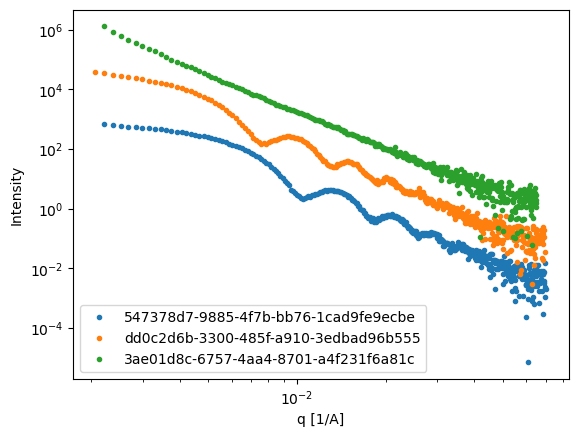

In [9]:
fig, ax = plt.subplots()

for i, (uuid_val, data) in enumerate(subtracted.items()):
    ax.loglog(data['q'], data['I']*20**i, label = uuid_val, ls = '', marker = '.')
    ax.set_xlabel('q [1/A]')
    ax.set_ylabel('Intensity')

ax.legend()

We have subtracted the background and selected data ranges with reasonable data quality. Now we can quantitatively evaluate our data.

## 3. Fitting structural models

SAXS can provide quantitative structural information about a sample. This requires solving the 'inverse problem'. SAXS measures the amplitude component of the forward fourier transform of spatial density variation of electrons. The 'inverse problem' refers to the process of re-constructing that spatial density of matter (ie, our sample's structure) from the incomplete picture we measured (we don't measure the phase component of the scattering). Typically, this is done by assuming a structural model (ie, spheres, rods, micelles, etc), then fitting parameters of that model using some form of least squares fitting by comparing scattering calculated from the model to the actual scattering we measure. [SasView](https://www.sasview.org/) is a commonly used open-source software package for performing this analysis. Their [sasmodels](https://github.com/SasView/sasmodels) package provides robust implementations of most structural models you would want to use. The `sasview_fitting` module in this library provides some lightweight wrappers around the sasmodels package to streamline fitting of select models for this project. We are making particles with the Stober synthesis, so we assume we are making spherical particles. The oscillations or 'wiggles' in two of the example measurements suggest we are making relatively monodisperse spheres. Let's fit a spherical model to these scattering measurements to estimate particle size. We will fit the models to the subtracted data

In [10]:
sphere_results = {}
for uuid_val, data in subtracted.items():

    # sasmodels uses its own data format, so convert to that 
    data_sas = io.df_to_sasdata(data)
    results, result_obj, problem  = sasview_fitting.fit_sphere(data_sas, polydispersity=True, r_init = 50)

    sphere_results[uuid_val] = (results, result_obj, problem)

Plot our fit results:

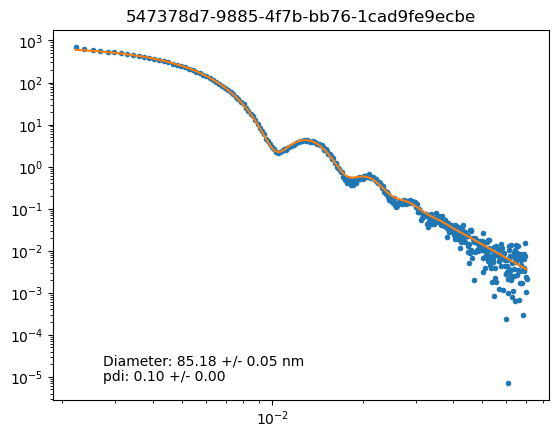

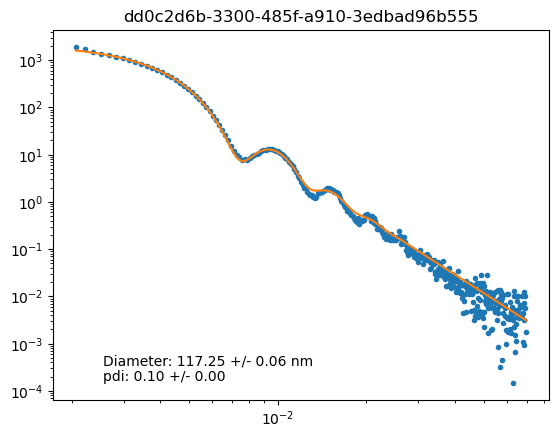

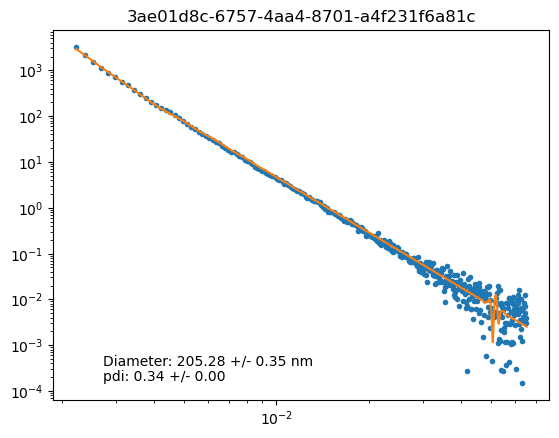

In [11]:
for uuid_val, results in sphere_results.items():
    results, result_obj, problem = results
    
    data = problem.fitness._data
    Icalc = problem.fitness.Iq_calc

    sphere_d = results['radius']*2/10 #sasview works in angstroms, we think in nm, and convert to diameter
    sphere_d_u = results['radius_uncertainty']*2/10
    sphere_pd = results['radius_pd']
    sphere_pd_u = results['radius_pd_uncertainty']

    fig, ax = plt.subplots()

    ax.loglog(data.x, data.y, label = 'measured', ls = '', marker = '.')
    ax.loglog(data.x, Icalc, label = 'fit')
    ax.text(0.1, 0.05, f'Diameter: {sphere_d:.2f} +/- {sphere_d_u:.2f} nm\npdi: {sphere_pd:.2f} +/- {sphere_pd_u:.2f}', transform = ax.transAxes)
    ax.set_title(uuid_val)

These look like reasonable fits for the first two samples. However the last example is a little suspect. I don't see any indication from the scattering measurement that this sample contains spheres, but the model fit is telling use we made 200 nm with mediocre polydispersity. We also have an issue with the numerical noise at q = 4e-2. Using my intuition, I would choose to discard this result. This illustrates some of the problems with using traditional SAXS fitting in automated data processing workflows. How would I encode this intuition into an automated system, without building a fragile web of rules based decision making that accounts for every possible edge case? This sounds fragile, biased, and difficult. We need a different approach to evaluate our SAXS data. 

## 4. Comparing SAXS measurements to target scattering

Let's consider our end goal for our automated processing pipeline. I am interested in using Bayesian optimization to optimize nanoparticle synthesis conditions for the synthesis of particles with an arbitrary target diameter using a self driving lab. To do this, I don't ultimately need to know the diameter of particles in samples. What I really need is a scalar metric value that tells my optimizer how 'good' a particular sample is relative to the target we are aiming to make. I can use a distance metric to directly compare measured scattering data to a calculated scattering profile for my target particles. The `target_comparison` module provides tools to do this comparison. 

First, we need to calculate our target scattering profile. We will need to define several parameters to do this. These parameters define our calculated scattering profile, and some other values we will need to clean up our measured data.

In [12]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [13]:
target_r_nm = 60
target_r_angs = target_r_nm*10
target_pdi = 0.08
sld_silica = 8.575
sld_etoh = 9.611

In [14]:
# calculate target scattering

q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

Text(0.5, 1.0, '120nm, 0.08 PDI target scattering')

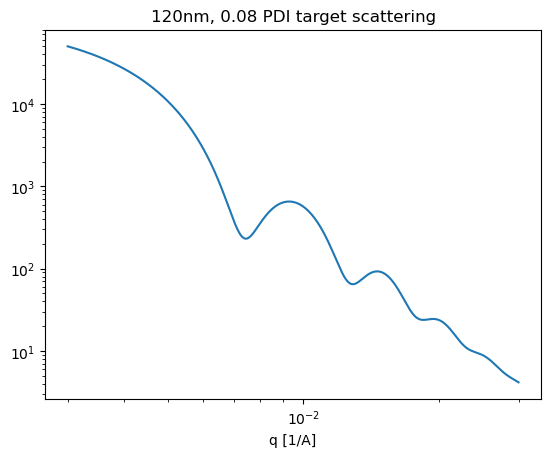

In [15]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')
ax.set_title(f'{target_r_nm*2}nm, {target_pdi} PDI target scattering')

#### Data cleaning
The distance metric we will be using to compare the target and measured scattering requires that both scattering datasets be on the same q grid, and is sensitive to excessive noise. We need to clean up our measured data to account for this. To do this we will denoise the measured data with a SavGol filter, interpolate it onto our `q_grid` with a spline fit, and scale it so that the intensities align with the target scattering. The `manipulate` module has functions to streamline these operations. 

In [16]:
# SavGol denoise filter parameters
savgol_n = 15
savgol_order = 3
# minimum data length - data with less than ~100 data points is due to valid data selection step in subtraction and is likley too noisy to do anything with.
min_data_len = 100

# spline fit parameters
s = 0.05
k = 3

#scale parameters
n_avg = 100

# Amplitude-phase distance parameters
optim = "DP"
grid_dim = 10

In [17]:
cleaned_data = {}

for uuid_val, data in subtracted.items():

    # clean up NANs and negative values
    data = data[data['q'] < q_max_subtract]
    data = data[~data['I'].isna()]
    data = data[data['I'] > 0] # drop negative values 

    
    I = data['I']
    q = data['q']
    I_log = np.log10(I.to_numpy())
    q_log = np.log10(q.to_numpy())
    
    I_savgol = manipulate.denoise_intensity(I_log, savgol_n = savgol_n, savgol_order = savgol_order)
    I_spline = manipulate.fit_interpolate_spline(q_log, I_savgol, q_grid, s = s, k = k)
    I_scaled = manipulate.scale_intensity_highqavg(I_spline, target_I, n_avg = n_avg)
    cleaned_data[uuid_val] = I_scaled


Always a good idea to sanity-check the cleaning results:

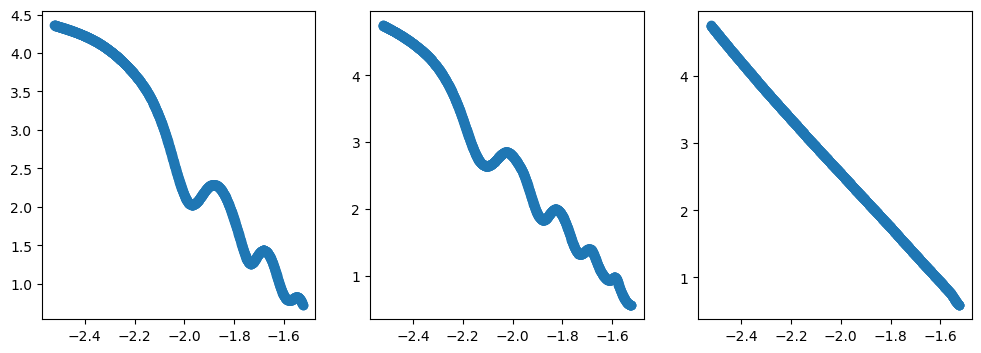

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for i, (uuid_val, I_scaled) in enumerate(cleaned_data.items()):

    ax[i].scatter(q_grid, I_scaled)

With cleaned data in hand, we can now calculate a distance metric. The most obvious distance metric is RMSE. That's a reasonable first choice:

In [19]:
rmse_dist = {}
for uuid_val, I_scaled in cleaned_data.items():
    raw_rmse = target_comparison.rmse_distance(I_scaled, target_I, log = False) # these intensities are already in log
    rmse_dist[uuid_val] = raw_rmse

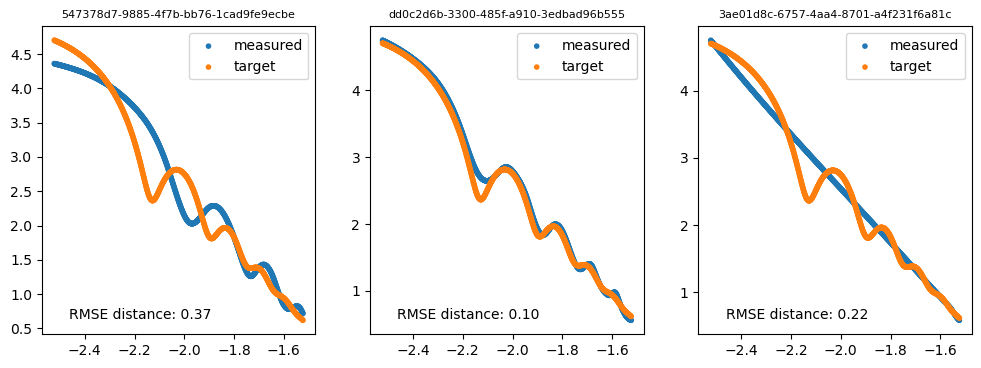

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for i, (uuid_val, I_scaled) in enumerate(cleaned_data.items()):

    rmse = rmse_dist[uuid_val]

    ax[i].scatter(q_grid, I_scaled, ls = '', marker = '.', label = 'measured')
    ax[i].scatter(q_grid, target_I, ls = '', marker = '.', label = 'target')
    ax[i].text(0.1, 0.05, f'RMSE distance: {rmse:.2f}', transform = ax[i].transAxes)
    ax[i].set_title(uuid_val, fontsize = 8)
    ax[i].legend()

RMSE distance does correctly identify that the middle sample is closest to our target. However, it ranks the sample on the right as closer to the target than the sample on the left. While this is strictly true in an RMSE sense, it does not agree with our intuition about the problem. My intuition suggests that the sample on the left is from a region of parameter space that is capable of making nicely monodisperse spheres, just at the wrong size for our target. I would expect the correct synthesis parameters to be close to those for the sample on the left. The sample on the right is not even in the ballpark. 
    We need a distance metric that understands the importance of shape in scattering data. Our research group, particularly Kiran Vaddi, has been working on developing a distance metric that works for shape-based data like SAXS and spectroscopy. This tool is called the Amplitude-Phase distance. It essentially works by warping the X-axis of the measured scattering intensity to minimize the distance to the 'target' scattering intensity, then calculating the remaining distance in the y or intensity axis. More information can be found on [GitHub](https://github.com/kiranvad/Amplitude-Phase-Distance), and in [this paper](https://pubs.rsc.org/en/content/articlehtml/2022/dd/d2dd00025c). 

In [21]:
ap_dist = {}
for uuid_val, I_scaled in cleaned_data.items():
    amplitude, phase = target_comparison.ap_distance(q_grid, I_scaled, target_I, optim = optim, grid_dim = grid_dim)
    ap_sum = amplitude + phase
    ap_dist[uuid_val] = ap_sum

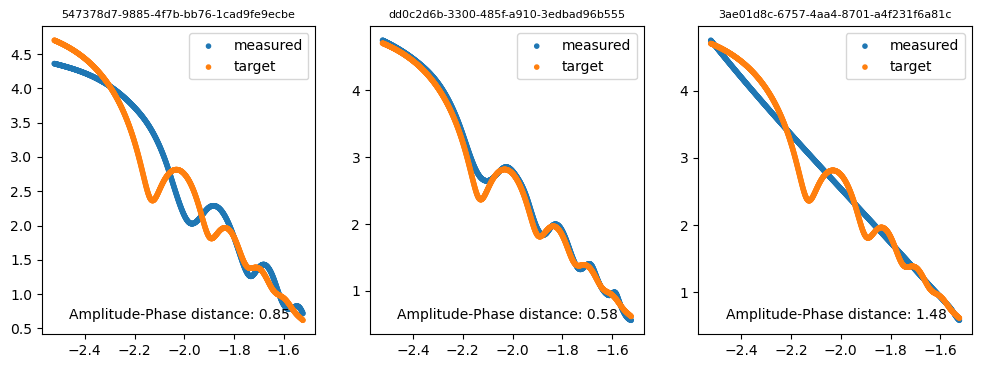

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (12, 4))

for i, (uuid_val, I_scaled) in enumerate(cleaned_data.items()):

    distance = ap_dist[uuid_val]

    ax[i].scatter(q_grid, I_scaled, ls = '', marker = '.', label = 'measured')
    ax[i].scatter(q_grid, target_I, ls = '', marker = '.', label = 'target')
    ax[i].text(0.1, 0.05, f'Amplitude-Phase distance: {distance:.2f}', transform = ax[i].transAxes)
    ax[i].set_title(uuid_val, fontsize = 8)
    ax[i].legend()

With this distance metric, the sample in the middle is still ranked as the 'best', but now the sample on the right is recognized as being much closer to the target than the example on the right. Now that we have an automated workflow that provides a scalar assessment of distance to an optimization target, we can build a closed-loop optimization pipeline using an optimizer like Bayesian optimization.  

## 5. Other functionality

- The `merge` module helps stitch together measurements made at multiple detector configurations for a sample. To span a large q-range, it is common to measure scattering at multiple sample-detector distances, then merge the resulting scattering profiles together. This module helps automate this process for batches of similar samples.
- The MCSAS test fit module contains prototypes for integrating data fitting with the [McSAS library](https://github.com/BAMresearch/McSAS). This uses monte carlo fitting to calculate parameter-free particle size distributions from scattering data. 